In [1]:
from fetch.match_results import read_joined

df, player_mapping, inverse_player_mapping = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [2]:
MIN_TRAIN_DATE = '2004-01-01'
MIN_TEST_DATE = '2016-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = df[
    (df['date'] >= MIN_TRAIN_DATE) &
    (df['date'] < MIN_TEST_DATE)
].copy()
test_df = df[
    (df['date'] >= MIN_TEST_DATE) &
    (df['date'] < MAX_TEST_DATE) &
    (df['__surface__'] == 'Hard') &
    (~df['comment'].isin(['Retired', 'Walkover']))
].copy()

In [3]:
from models.logit.base import get_X_y

train_X, train_y = get_X_y(train_df, player_mapping)
test_X, test_y = get_X_y(test_df, player_mapping)

In [4]:
from models.logit.base import sipko_weights

DISCOUNT = 0.8
FLAT_TIME = 1.0
PRIOR = 0.
LMBDA = 1.

time_weights = sipko_weights(
    train_df['date'].max(),
    train_df,
    DISCOUNT,
    flat_time=FLAT_TIME
)
surface_weights = train_df['__surface__'].map(
    lambda x: {
        'Hard': 1.0,
        'Clay': 0.8,
        'Grass': 1.0,
        'Indoor': 1.0 
    }[x]
)
sample_weights = time_weights * surface_weights

In [5]:
def get_game_weights(df, alpha=1.):
    game_percentage = df['wgames'] / df['total_games']
    return (alpha * game_percentage + (1 - alpha) * game_percentage.mean())
    # return df['wgames'] / df['total_games']

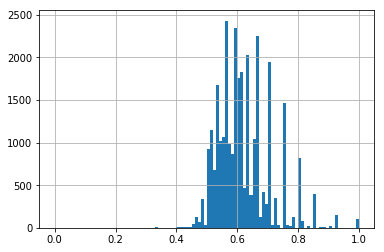

In [6]:
%matplotlib inline
get_game_weights(train_df, alpha=1.).hist(bins=100)

In [7]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

out = []
for alpha in np.linspace(0, 1, 21):
    print alpha
    game_weights = get_game_weights(train_df, alpha=alpha)
    my_weights = sample_weights * game_weights
    logit = LogisticRegression(C=0.4)
    logit.fit(train_X, train_y, sample_weight=my_weights)
    logit.coef_
    preds = logit.predict_proba(test_X)[:, 1]
    auc = roc_auc_score(test_y, preds)
    out.append((alpha, auc))

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


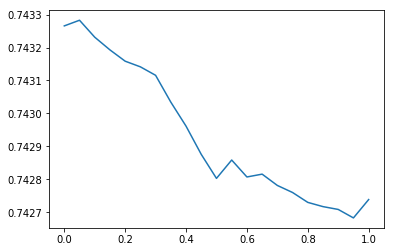

In [8]:
from matplotlib import pyplot as plt


plt.plot(zip(*out)[0], zip(*out)[1])

#### Player Weights 

In [ ]:
from collections import Counter

win_counts = Counter(dict(train_df['winner'].value_counts()))
lose_counts = Counter(dict(train_df['loser'].value_counts()))
player_counts = win_counts + lose_counts
train_df['p1_count'] = train_df['p1'].map(lambda x: player_counts[x])
train_df['p2_count'] = train_df['p2'].map(lambda x: player_counts[x])

def get_player_weights(df, alpha):
    return (df['p1_count'] ** alpha) * (df['p2_count'] ** alpha)

In [ ]:
out = []
for alpha in np.linspace(-2, 2, 51):
    print alpha
    player_weights = get_player_weights(train_df, alpha) 
    my_weights = sample_weights * game_weights
    logit = LogisticRegression(C=0.4)
    logit.fit(train_X, train_y, sample_weight=player_weights)
    logit.coef_
    preds = logit.predict_proba(test_X)[:, 1]
    auc = roc_auc_score(test_y, preds)
    out.append((alpha, auc))

In [ ]:
out

In [ ]:
from matplotlib import pyplot as plt

plt.plot(zip(*out)[0], zip(*out)[1])

#### Try sets instead of games

In [12]:
def get_set_weights(df, alpha=1.):    
    set_percentage = df['wsets'] / (df['wsets'] + df['lsets'])
    # ret_weights = (alpha * set_percentage + (1 - alpha) * set_percentage.mean())
    set_percentage[
        (df['wsets'] == 0) |
        (df['comment'].isin(('Retired', 'Walkover')))
    ] = set_percentage.mean()
    ret_weights = np.power(set_percentage, alpha)
    return ret_weights

In [14]:
set_weights = get_set_weights(train_df)

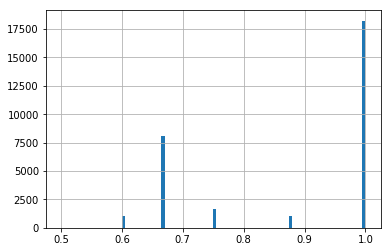

In [15]:
set_weights.hist(bins=100)

In [16]:
out = []
for alpha in np.linspace(-1, 1, 41):
    print alpha
    set_weights = get_set_weights(train_df, alpha)
    logit = LogisticRegression(C=0.4)
    logit.fit(train_X, train_y, sample_weight=set_weights)
    logit.coef_
    preds = logit.predict_proba(test_X)[:, 1]
    auc = roc_auc_score(test_y, preds)
    out.append((alpha, auc))

-1.0
-0.95
-0.9
-0.85
-0.8
-0.75
-0.7
-0.65
-0.6
-0.55
-0.5
-0.45
-0.4
-0.35
-0.3
-0.25
-0.2
-0.15
-0.1
-0.05
0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


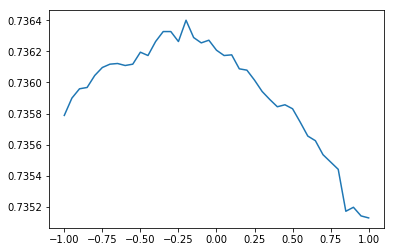

In [17]:
from matplotlib import pyplot as plt


plt.plot(zip(*out)[0], zip(*out)[1])

In [18]:
out

[(-1.0, 0.73578780918425069),
 (-0.94999999999999996, 0.73589922693224086),
 (-0.90000000000000002, 0.73595922110423562),
 (-0.84999999999999998, 0.73596779170023474),
 (-0.80000000000000004, 0.73604492706422808),
 (-0.75, 0.7360963506402235),
 (-0.69999999999999996, 0.73611777713022164),
 (-0.64999999999999991, 0.73612206242822142),
 (-0.59999999999999998, 0.73610920653422229),
 (-0.55000000000000004, 0.73611777713022164),
 (-0.5, 0.73619491249421487),
 (-0.44999999999999996, 0.73617348600421673),
 (-0.39999999999999991, 0.73626347726220875),
 (-0.34999999999999998, 0.73632775673220319),
 (-0.29999999999999993, 0.73632775673220308),
 (-0.25, 0.73626347726220875),
 (-0.19999999999999996, 0.73640060679819674),
 (-0.14999999999999991, 0.73628918905020657),
 (-0.099999999999999978, 0.73625490666620963),
 (-0.049999999999999933, 0.7362720478582081),
 (0.0, 0.73620776838821378),
 (0.050000000000000044, 0.73617348600421673),
 (0.10000000000000009, 0.7361777713022164),
 (0.15000000000000013, 